In [1]:
import pandas as pd
import json
from sklearn.metrics import ndcg_score
from collections import defaultdict

# Load your original test set
test_df = pd.read_csv('./subset_ratings.csv')  # or the same one used in both notebooks
test_df = test_df[test_df.movieId.notna()]

# Load prediction JSONs
with open("predictions/cbf_top10_subset.json") as f:
    preds_cbf = json.load(f)

with open("predictions/hybrid_top10_subset.json") as f:
    preds_hybrid = json.load(f)


In [2]:
def precision_recall_at_k(pred_dict, test_df, K=10):
    hit_count, rec_count, rel_count = 0, 0, 0

    for u, grp in test_df.groupby('userId'):
        u = str(u)  # keys in JSON are string-typed
        if u not in pred_dict:
            continue

        true_items = set(grp.movieId)
        pred_items = pred_dict[u][:K]

        hits = len(true_items.intersection(pred_items))
        hit_count += hits
        rec_count += K
        rel_count += len(true_items)

    precision = hit_count / rec_count if rec_count else 0
    recall = hit_count / rel_count if rel_count else 0
    return precision, recall


In [3]:
def ndcg_at_k(pred_dict, test_df, K=10):
    scores, truths = [], []
    for u, grp in test_df.groupby('userId'):
        u = str(u)
        if u not in pred_dict:
            continue
        true_items = set(grp.movieId)
        pred_items = pred_dict[u][:K]
        rel = [1 if m in true_items else 0 for m in pred_items]
        scores.append(rel)
        truths.append(sorted(rel, reverse=True))
    return ndcg_score(truths, scores)


In [4]:
K = 10

# Precision and Recall
prec_cbf, rec_cbf = precision_recall_at_k(preds_cbf, test_df, K)
prec_hyb, rec_hyb = precision_recall_at_k(preds_hybrid, test_df, K)

# NDCG
ndcg_cbf = ndcg_at_k(preds_cbf, test_df, K)
ndcg_hyb = ndcg_at_k(preds_hybrid, test_df, K)

# Print comparison
print(f"{'Model':<10} | Precision@{K} | Recall@{K} | NDCG@{K}")
print("-" * 45)
print(f"{'CBF':<10} | {prec_cbf:.4f}       | {rec_cbf:.4f}   | {ndcg_cbf:.4f}")
print(f"{'Hybrid':<10} | {prec_hyb:.4f}       | {rec_hyb:.4f}   | {ndcg_hyb:.4f}")


Model      | Precision@10 | Recall@10 | NDCG@10
---------------------------------------------
CBF        | 0.0305       | 0.0015   | 0.1195
Hybrid     | 0.1965       | 0.0096   | 0.4390


In [5]:
# Simulate Cold Start Users
import random

# Simulate 5% of users as cold-start (keep only 2 ratings in training)
cold_users = set(random.sample(list(test_df['userId'].unique()), k=int(0.05 * test_df['userId'].nunique())))
train_rows, test_rows = [], []

for user, group in test_df.groupby('userId'):
    if user in cold_users:
        sample = group.sample(n=min(2, len(group)), random_state=42)
        train_rows.append(sample)
        test_rows.append(group.drop(sample.index))
    else:
        train_rows.append(group)

train_df_cold_users = pd.concat(train_rows)
test_df_cold_users = pd.concat(test_rows)

print(f"Cold-start user count: {len(cold_users)}")
print(f"Training ratings: {len(train_df_cold_users)}, Test ratings: {len(test_df_cold_users)}")

Cold-start user count: 500
Training ratings: 1974034, Test ratings: 104591


In [7]:
# Evaluate Precision, Recall, NDCG for Cold-Start Users
prec_cbf_cold, rec_cbf_cold = precision_recall_at_k(preds_cbf, test_df_cold_users, K=10)
ndcg_cbf_cold = ndcg_at_k(preds_cbf, test_df_cold_users, K=10)

prec_hyb_cold, rec_hyb_cold = precision_recall_at_k(preds_hybrid, test_df_cold_users, K=10)
ndcg_hyb_cold = ndcg_at_k(preds_hybrid, test_df_cold_users, K=10)

# Display Results
print("Cold Start Evaluation for Users with Few Ratings")
print(f"{'Model':<10} | Precision@10 | Recall@10 | NDCG@10")
print("-" * 45)
print(f"{'CBF':<10} | {prec_cbf_cold:.4f}       | {rec_cbf_cold:.4f}   | {ndcg_cbf_cold:.4f}")
print(f"{'Hybrid':<10} | {prec_hyb_cold:.4f}       | {rec_hyb_cold:.4f}   | {ndcg_hyb_cold:.4f}")

Cold Start Evaluation for Users with Few Ratings
Model      | Precision@10 | Recall@10 | NDCG@10
---------------------------------------------
CBF        | 0.0370       | 0.0019   | 0.1103
Hybrid     | 0.2255       | 0.0098   | 0.4411


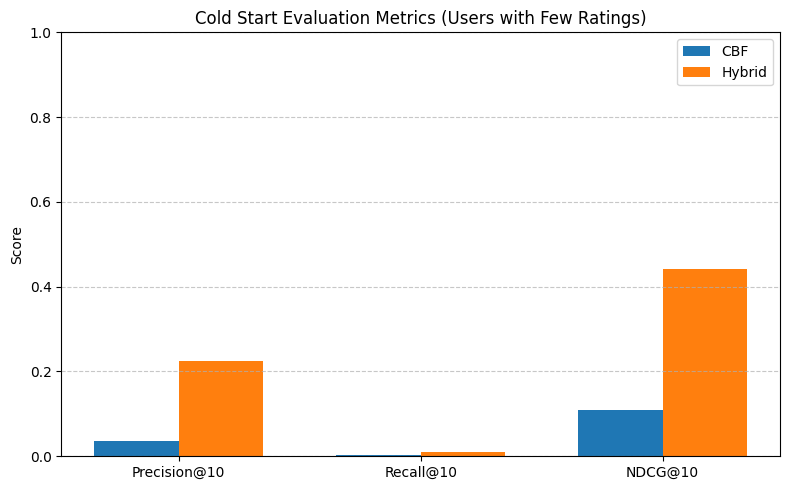

In [8]:
# Visualization: Cold Start Evaluation
import matplotlib.pyplot as plt

# Data from evaluation (make sure these are already computed in previous cell)
metrics = ['Precision@10', 'Recall@10', 'NDCG@10']
cbf_scores = [prec_cbf_cold, rec_cbf_cold, ndcg_cbf_cold]
hyb_scores = [prec_hyb_cold, rec_hyb_cold, ndcg_hyb_cold]

x = range(len(metrics))
plt.figure(figsize=(8, 5))
plt.bar(x, cbf_scores, width=0.35, label='CBF')
plt.bar([i + 0.35 for i in x], hyb_scores, width=0.35, label='Hybrid')
plt.xticks([i + 0.175 for i in x], metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Cold Start Evaluation Metrics (Users with Few Ratings)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()